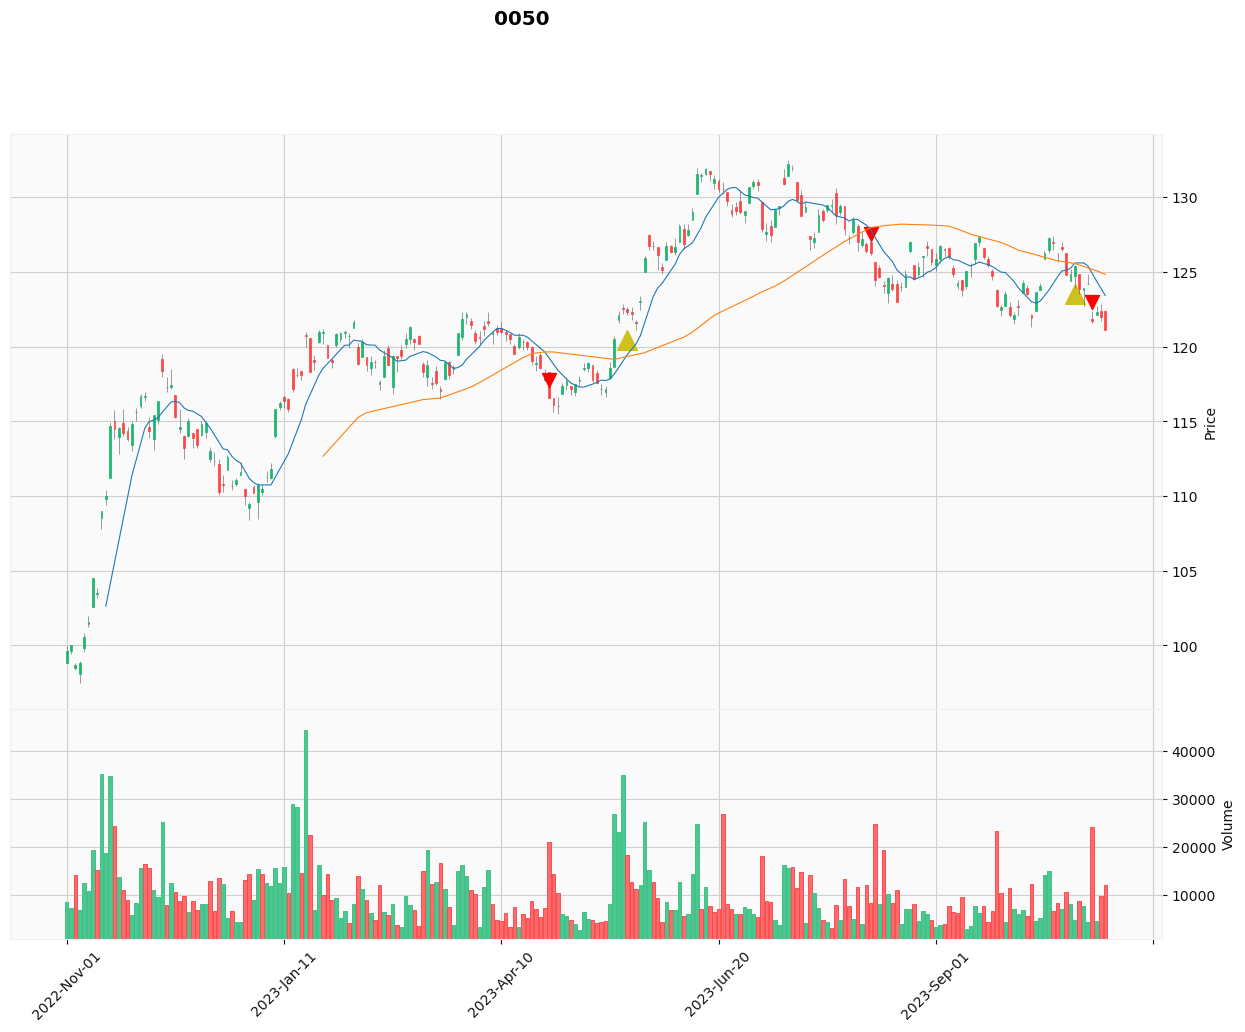

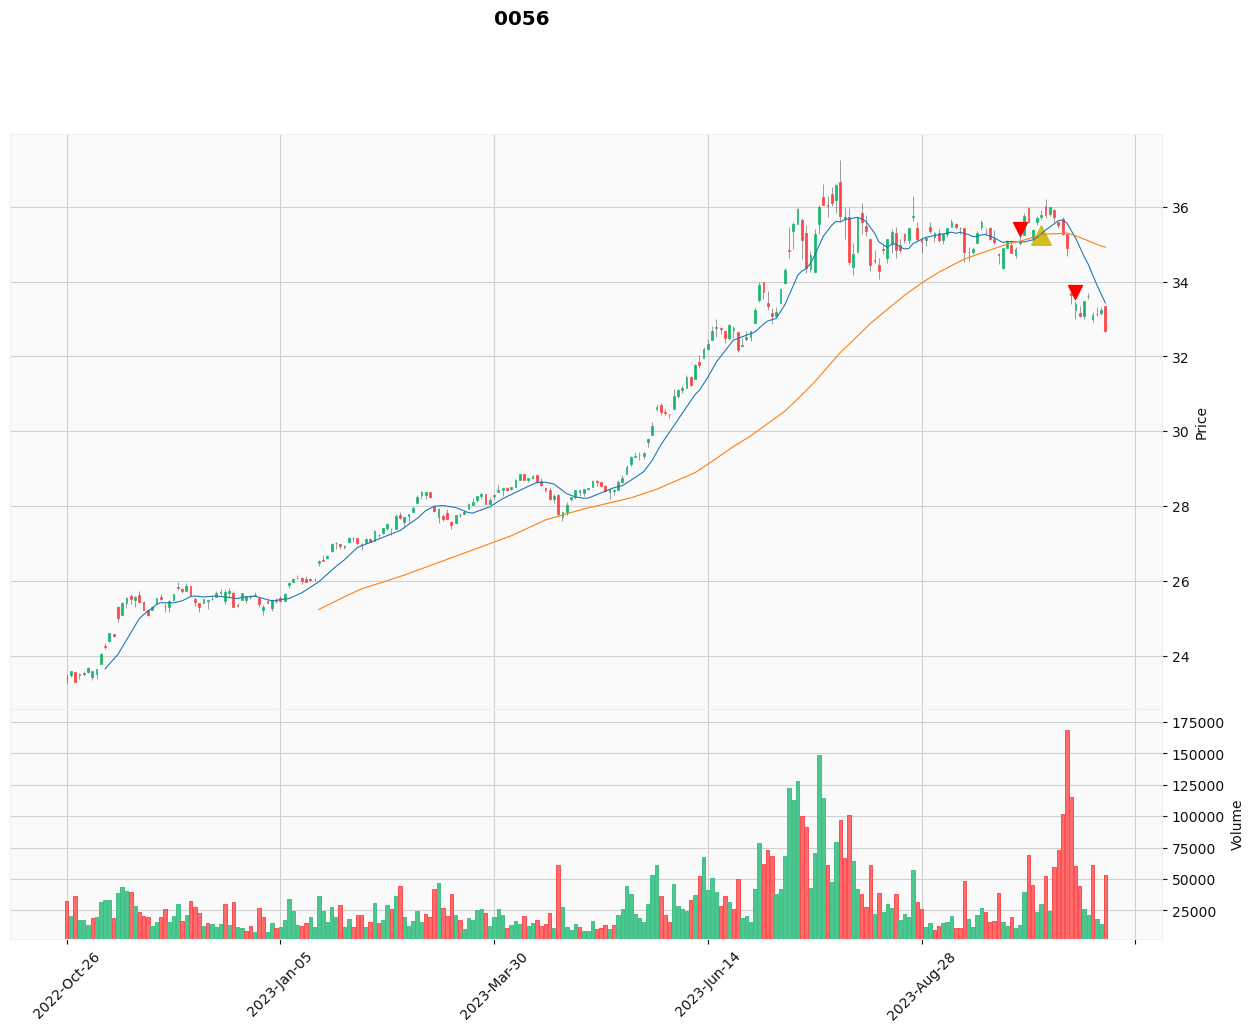

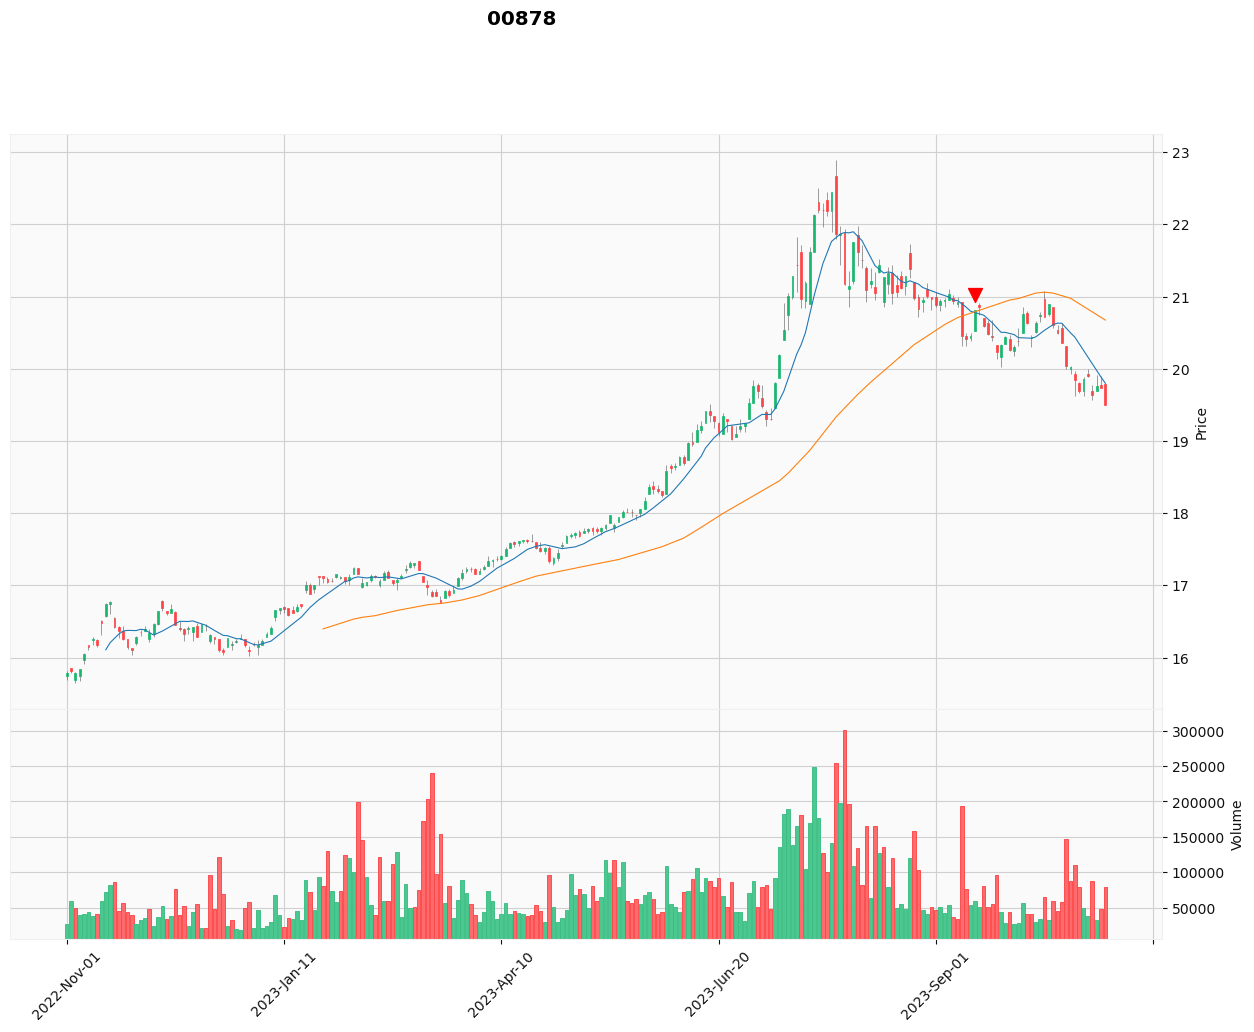

,0,1,2,3,4
0,Cost ($),Income ($),Net Income ($),Holding ROI (%),ROI (%)
1,248053,246952,-1100.6,0.177879,-0.00443696
2,35841,33252.2,-2588.8,0.283879,-0.0722301
3,0,0,0,0.190256,0


In [15]:
'''
黃金交叉：10日MA向上突破60日MA
死亡交叉：10日MA向下突破60日MA
不管關盤價格
只買進或賣出一張
'''

import mplfinance as mpf

import pandas as pd
import numpy as np

# 讀取 csv 檔
ticker1 = pd.read_csv("0050.csv")
ticker2 = pd.read_csv("0056.csv")
ticker3 = pd.read_csv("00878.csv")

tickers_name = ["0050", "0056", "00878"]

# 將欄位名稱更改為英文
ticker1.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
ticker2.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
ticker3.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# 將日期設定為索引標籤
ticker1 = ticker1.set_index('Date')
ticker2 = ticker2.set_index('Date')
ticker3 = ticker3.set_index('Date')

# 將日期蘭為由 string 轉為 datetime.datetime
ticker1.index = pd.to_datetime(ticker1.index)
ticker2.index = pd.to_datetime(ticker2.index)
ticker3.index = pd.to_datetime(ticker3.index)

# 排序資料
ticker1 = ticker1.sort_index()
ticker2 = ticker2.sort_index()
ticker3 = ticker3.sort_index()

tickers = []

# 將資料統一存進陣列內，方便跑迴圈
tickers.append(ticker1)
tickers.append(ticker2)
tickers.append(ticker3)

detail = [['Cost ($)', 'Income ($)', 'Net Income ($)', 'Holding ROI (%)', 'ROI (%)']]

unit = 1 # 每次購買張數

for j in range(3):
    buy_unit = 0
    sell_unit = 0

    cost = 0
    income = 0
    total_stock = 0

    gain = 0

    stock_close = [float(line) for line in tickers[j]['Close']]
    stock_high = [float(line) for line in tickers[j]['High']]
    stock_low = [float(line) for line in tickers[j]['Low']]


    temp_detail = [] # 資料暫存

    data = tickers[j]

    MOVING_WINDOW_1 = 10
    MOVING_WINDOW_2 = 60
    # 利用 pandas.DataFrame.rolling() 計算移動平均線
    data['ma_10'] = data['Close'].rolling(MOVING_WINDOW_1).mean()
    data['ma_60'] = data['Close'].rolling(MOVING_WINDOW_2).mean()


    # 初始化 'buy' & 'sell' 欄位為 0
    data['buy'] = np.zeros(tickers[j].shape[0])
    data['sell'] = np.zeros(tickers[j].shape[0])

    # 由於 60日線 資料較少，所以由 60日線 開始的地方開始計算
    for i in range(MOVING_WINDOW_2, data.shape[0]):

        # 當 10日線 向上突破 60日線 時，為買進訊號
        if (((data.iloc[i]['ma_10'] > data.iloc[i]['ma_60']) and
            (data.iloc[i-1]['ma_10'] < data.iloc[i-1]['ma_60'])) and
            (data.iloc[i]['ma_10'] > data.iloc[i-1]['ma_10'])):

            data.loc[(data.index[i], 'buy')] = 1

            buy_unit += unit                                            # 買入一張
            total_stock += unit
            cost += round(stock_close[i] * 1.001425 * unit * 1000, 1)   # 計算總支出
            # gain -= round(stock_close[i] * 1.001425 * unit * 1000)

        # 當 10日線 向上突破 60日線 時，為賣出訊號
        if (((data.iloc[i]['ma_10'] < data.iloc[i]['ma_60']) and
            (data.iloc[i-1]['ma_10'] > data.iloc[i-1]['ma_60'])) and
            (data.iloc[i]['ma_10'] < data.iloc[i-1]['ma_10'])):

            data.loc[(data.index[i], 'sell')] = 1
            
            if total_stock != 0:                                              # 持有股票才能賣出
                sell_unit += unit                                             # 賣出一張
                total_stock -= unit
                income += round(stock_close[i] * 0.995575 * unit * 1000, 1)
                # gain += round(stock_close[i] * 1.001425 * unit * 1000)

    # 將資料存入暫存
    temp_detail.append(cost)                                                        # 支出
    temp_detail.append(income)                                                      # 收入
    temp_detail.append(income - cost)                                               # 淨收入
    temp_detail.append(abs((stock_close[0] - stock_close[-1]) / stock_close[-1]))   # 持有獲利百分比
    if cost != 0:                                                                    
        temp_detail.append((income - cost) / cost)                                  # return of investment
    else:
        temp_detail.append(0)

    # 將暫存區資料存入 detail
    detail.append(temp_detail)

    plots = []

    # 買進與賣出的位置
    buy, sell = [], []

    # 調整符號位置，避免擋到圖例
    for index, row in data.iterrows():
        buy.append(row['Close']*0.985 if row['buy'] else np.nan)
        sell.append(row['Close']*1.01 if row['sell'] else np.nan)

    # np.isnan(sell) determine the value is nan or not
    # count_nonzero(np.isnan(sell)) counts how many nan we have
    # if nan amount equal the length of array, we don't have sell record
    if not np.count_nonzero(np.isnan(sell)) == len(sell):
        plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))

    if not np.count_nonzero(np.isnan(buy)) == len(buy):
        plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

    mpf.plot(data,
             title=tickers_name[j],
             addplot=plots,
             type='candle',  # 蠟燭圖
             mav=(MOVING_WINDOW_1, MOVING_WINDOW_2),  # 移動平均線窗口
             volume=True,  # 交易量
             figscale=2,  # 圖表大小
             style='yahoo')  # 色彩風格
    
detail = pd.DataFrame(detail)
detail